## Dogs v Cats

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [2]:
PATH = "data/dogscats/"
sz = 224
arch = resnet34
bs = 64

In [3]:
m = arch(True) # pretrained=True

In [4]:
m

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [5]:
m = nn.Sequential(*children(m)[:-2], # remove the final layer: Linear(in_features=512, out_features=1000)
                  nn.Conv2d(512, 2, 3, padding=1),  # output 2 filters (2 classes)
                  nn.AdaptiveAvgPool2d(1), Flatten(), # AdaptiveAvgPooling2d: The output is of size H x W, for any input size. The number of output features is equal to the number of input planes.
                  nn.LogSoftmax())

In [6]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [7]:
learn = ConvLearner.from_model_data(m, data)

In [8]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 56

In [10]:
m[-5].trainable

True

In [16]:
m[-1], m[-4]

(LogSoftmax(),
 Conv2d (512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

In [12]:
learn.freeze_to(-4) # just train the last layer

In [13]:
m[-1].trainable

True

In [14]:
m[-4].trainable

True

In [15]:
m[-5].trainable

False

In [17]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.14948    0.247789   0.980957  



[0.24778913, 0.98095703125]

In [18]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.108523   0.073568   0.990723  



[0.073568255, 0.99072265625]

## CAM

CAM = Class Activation Maps

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = to_np(output)
    def remove(self): self.hook.remove()

In [22]:
x,y = next(iter(data.val_dl)) # [64, 3, 224, 224], [64]  where 64 is batch size
x,y = x[None,1], y[None,1] # [1, 3, 224, 224], [1]

#>>> a = np.array([[1,2],[3,4]])
#>>> a[None,1]
#array([[3, 4]])
#>>> a[1]
#array([3, 4])
#>>> a[:,1]
#array([2, 4])

vx = Variable(x.cuda(), requires_grad=True)

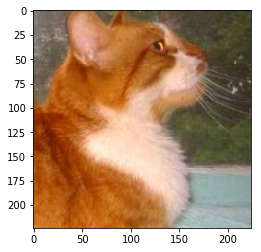

In [24]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [39]:
m[-4], m[-3] # The average pooling layer takes (2x7x7) grid coming out of final conv layer and average out how much each part is “cat-like”

(Conv2d (512, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 AdaptiveAvgPool2d(output_size=1))

In [26]:
sf = SaveFeatures(m[-4]) # set hook. every time it calculates a layer, it calls this hook.
py = m(Variable(x.cuda())) # py is predictions
sf.remove()

py = np.exp(to_np(py)[0]); py # (2,)

array([1., 0.], dtype=float32)

In [30]:
feat = np.maximum(0, sf.features[0])
feat.shape

(2, 7, 7)

In [32]:
f2=np.dot(np.rollaxis(feat,0,3), py) # np.rollaxis(feat,0,3) returns (7, 7, 2) where feat shape is (2, 7, 7)
# normalize to 0.0-1.0
f2-=f2.min()
f2/=f2.max()
f2 # (7, 7)

#>>> a = np.ones((3,4,5,6))
#>>> np.rollaxis(a, 0, 3).shape # move axis 0 into the position of axis 3
#(4, 5, 3, 6)

array([[0.18096, 0.2856 , 0.35293, 0.40698, 0.45721, 0.41488, 0.24897],
       [0.25737, 0.4287 , 0.55593, 0.65191, 0.74634, 0.71132, 0.45964],
       [0.39886, 0.64064, 0.7775 , 0.86709, 0.97825, 0.93532, 0.62046],
       [0.43209, 0.6764 , 0.80796, 0.91821, 1.     , 0.93029, 0.59863],
       [0.30181, 0.45433, 0.58915, 0.73661, 0.86353, 0.79795, 0.49237],
       [0.12513, 0.17455, 0.27813, 0.44983, 0.58618, 0.54223, 0.32223],
       [0.     , 0.     , 0.01094, 0.12353, 0.21437, 0.19878, 0.11088]], dtype=float32)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


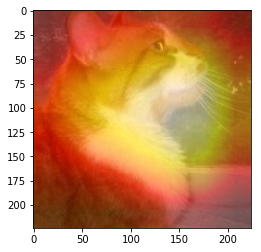

In [34]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [35]:
learn.unfreeze()
learn.bn_freeze(True)

In [36]:
lr=np.array([1e-6,1e-4,1e-2])

In [37]:
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.10189    0.072934   0.991211  
    1      0.095344   0.069264   0.991211                     



[0.069263905, 0.9912109375]

In [40]:
# accuracy(*learn.TTA())

log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y)

0.9915

In [41]:
learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.101585   0.065855   0.991699  
    1      0.085696   0.071362   0.990234                     



[0.07136191, 0.990234375]

In [42]:
# accuracy(*learn.TTA())

log_preds, y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds, y)

0.991